# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import scipy
import random
import ot
import sys
sys.path.append("../src")

from utils import *
from mitigation_fct import *
from distance import *
from GEMS3_base_explainer import *
from matplotlib.colors import LogNorm
import time

# Creating dataset

## Utils

#### Distance evaluation fonction

In [2]:
def evaluate_dist_pert_W(df, n_iter, n_sample, dist_fct, cols = ['S', 'Pred'], agg_fct = np.mean):
    arr_dist = np.zeros(n_iter)
    for i in tqdm(range(n_iter)):
        df_sample = df.sample(n_sample)
        arr_dist[i] = dist_fct(df_sample[cols].values, df[cols].values)
    return agg_fct(arr_dist)

def evaluate_dist_pert_S(df, n_iter, n_sample, dist_fct, cols = ['S', 'Pred'], agg_fct = np.mean):
    arr_dist = np.zeros(n_iter)
    for i in tqdm(range(n_iter)):
        df_sample_1 = df.sample(n_sample)
        df_sample_2 = df.sample(n_sample)
        arr_dist[i] = dist_fct(df_sample_1[cols].values, df_sample_2[cols].values)
    return agg_fct(arr_dist)

In [3]:
def test_fct_dist(df, n_iter, n_sample, dist_fct_1, dist_fct_2, cols = ['S', 'Pred'], threshold = 1e-6, agg_fct = np.mean):
    for i in tqdm(range(n_iter)):
        df_sample_1 = df.sample(n_sample)
        df_sample_2 = df.sample(n_sample)
        boolean = ( abs(dist_fct_1(df_sample_1[cols].values, df_sample_2[cols].values) - dist_fct_2(df_sample_1[cols].values, df_sample_2[cols].values))     < threshold)
        if not boolean:
            return False, i, abs(dist_fct_1(df_sample_1[cols].values, df_sample_2[cols].values) - dist_fct_2(df_sample_1[cols].values, df_sample_2[cols].values))
    return 'the two distance function seem to be equivalent'

### Simulation

In [4]:
def create_dataset_s_binary(number_ind : int = 100 ,
                            s_mean     : float  = 0.5 ,
                            s_mean_2   : float  = 0.5 ,
                            y_mean_s1  : float  = 0.5 ,
                            y_mean_s0  : float  = 0.5 ,
                            pred_mean_y1_s1 : float= 0.5 ,
                            pred_mean_y1_s0 : float= 0.5 ,
                            pred_mean_y0_s1 : float= 0.5 ,
                            pred_mean_y0_s0 : float= 0.5 ) -> pd.DataFrame:

    #Generate the S column using s_mean
    S = np.random.binomial(size=number_ind, n=1, p = s_mean)

    S2 = np.random.binomial(size=number_ind, n=1, p = s_mean_2)

    #Generate the Y column from the S column using y_mean_s1 and y_mean_s0
    Y = S * np.random.binomial(size=number_ind, n=1, p = y_mean_s1) + (1-S) * np.random.binomial(size=number_ind, n=1, p = y_mean_s0)

    #Generate the Pred column from the S and Y columns using pred_mean_y1_s1, pred_mean_y1_s0, pred_mean_y0_s1, pred_mean_y0_s0
    Pred =  S * Y * np.random.binomial(size=number_ind, n=1, p = pred_mean_y1_s1) + S * (1-Y) * np.random.binomial(size=number_ind, n=1, p = pred_mean_y0_s1) + (1-S) * Y * np.random.binomial(size=number_ind, n=1, p = pred_mean_y1_s0) + (1-S) * (1-Y) * np.random.binomial(size=number_ind, n=1, p = pred_mean_y0_s0)

    #Create the dataframe
    df = pd.DataFrame({'S': S, 'S2': S2, 'Y': Y, 'Pred': Pred})
    return df

### Information fct

In [5]:
def printout_df_information(df):
    s_mean = df.S.mean()
    y_mean_s1 = df[df.S == 1].Y.mean()
    s_mean_s0 = df[df.S == 0].Y.mean()
    pred_mean_y1_s1 = df[(df.S == 1) & (df.Y == 1)].Pred.mean()
    pred_mean_y1_s0 = df[(df.S == 0) & (df.Y == 1)].Pred.mean()
    pred_mean_y0_s1 = df[(df.S == 1) & (df.Y == 0)].Pred.mean()
    pred_mean_y0_s0 = df[(df.S == 0) & (df.Y == 0)].Pred.mean()
    PY1S1 = (df[(df.S == 1) & (df.Y == 1)].shape[0]/df[df.S == 1].shape[0])
    PY1S0 = (df[(df.S == 0) & (df.Y == 1)].shape[0]/df[df.S == 0].shape[0])
    PPred1S1 = (df[(df.S == 1) & (df.Pred == 1)].shape[0]/df[df.S == 1].shape[0])
    Pred1S0  = (df[(df.S == 0) & (df.Pred == 1)].shape[0]/df[df.S == 0].shape[0])
    DI_Y = min(PY1S1,PY1S0) / max(PY1S1,PY1S0)
    DI_Pred = min(PPred1S1,Pred1S0) / max(PPred1S1,Pred1S0)
    print(f"Mean of S: {s_mean.round(2)}")
    print(f"Mean of Y: {df.Y.mean().round(2)}")
    print(f"Mean of Y when S=1: {y_mean_s1.round(2)}")
    print(f"Mean of Y when S=0: {s_mean_s0.round(2)}")
    print(f"Mean of Pred when S=1 and Y=1: {pred_mean_y1_s1.round(2)}")
    print(f"Mean of Pred when S=0 and Y=1: {pred_mean_y1_s0.round(2)}")
    print(f"Mean of Pred when S=1 and Y=0: {pred_mean_y0_s1.round(2)}")
    print(f"Mean of Pred when S=0 and Y=0: {pred_mean_y0_s0.round(2)}")
    print(f"The model accuracy is: {np.round(df[df.Y == df.Pred].shape[0]/df.shape[0], 2)}")
    print(f"The data disparate impact (DI) is: {np.round(DI_Y, 2)}")
    print(f"The network disparate impact (DI) is: {np.round(DI_Pred, 2)}")
    return

### Miti Shortcut

In [ ]:
Entropic_balanced     = lambda df,  S_name,  Y_name, Pred_name,  DI_target,  dic_name_to_index_mapping : Gems_fair_mitigation(df,  S_name,  Y_name, Pred_name,  DI_target,  dic_name_to_index_mapping, delta_type = 'mean')
Entropic_proportional = lambda df,  S_name,  Y_name, Pred_name,  DI_target,  dic_name_to_index_mapping : Gems_fair_mitigation(df,  S_name,  Y_name, Pred_name,  DI_target,  dic_name_to_index_mapping, delta_type = 'number')
Matching_W_XSY        = lambda df,  S_name,  Y_name, Pred_name,  DI_target,  dic_name_to_index_mapping : find_sampling_wasserstein_DI(df.values, dic_name_to_index_mapping[S_name], dic_name_to_index_mapping[Pred_name], threshold = DI_target)[0]

def mitigation_w(arr,
                S_index = 0,
                Y_index = 3,
                threshold = 0.8,
                speed = 1,
                ):
    new_arr, translation, bins = find_translation_DI(arr,
                                        S_index = S_index,
                                        Y_index = Y_index,
                                        threshold = threshold,
                                        speed = speed,
                                        bool_return_all = True)
    wass_dist = (translation**2).sum()/(2*len(arr))
    return new_arr, wass_dist

## Actually creating it

In [6]:
df = create_dataset_s_binary(number_ind     = 20000,
                            s_mean          = 0.5 + 0.2,
                            s_mean_2        = 0.8,
                            y_mean_s1       = 0.5 + 0.1,
                            y_mean_s0       = 0.5 - 0.1,
                            pred_mean_y1_s1 = 0.9,
                            pred_mean_y1_s0 = 0.4,
                            pred_mean_y0_s1 = 0.2,
                            pred_mean_y0_s0 = 0.05)
dic_name_to_index_mapping = {'S' : 0, 'S2' : 1, 'Y' : 2, 'Pred' : 3}

In [7]:
df_sample = df.sample(500)
np.unique(df_sample[['S', 'Pred']], axis = 0, return_counts=True)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]], dtype=int32),
 array([105,  25, 136, 234]))

In [8]:
printout_df_information(df)

Mean of S: 0.71
Mean of Y: 0.54
Mean of Y when S=1: 0.6
Mean of Y when S=0: 0.39
Mean of Pred when S=1 and Y=1: 0.91
Mean of Pred when S=0 and Y=1: 0.4
Mean of Pred when S=1 and Y=0: 0.2
Mean of Pred when S=0 and Y=0: 0.06
The model accuracy is: 0.82
The data disparate impact (DI) is: 0.65
The network disparate impact (DI) is: 0.3


# Distance estimation

In [10]:
mean_w, std_w, min_w, max_w  = evaluate_dist_pert_W(df, n_iter = 1000, n_sample = 2000, dist_fct = KL_multidim_gaussian_approx, cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr), np.min(arr), np.max(arr)))
mean_s, std_s, min_s, max_s  = evaluate_dist_pert_S(df, n_iter = 1000, n_sample = 2000, dist_fct = KL_multidim_gaussian_approx, cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr), np.min(arr), np.max(arr)))
print(f"Mean KL whole dataset distance: {mean_w} +/- {std_w}, max & min = {max_w} & {min_w}")
print(f"Mean KL sample dataset distance: {mean_s} +/- {std_s}, max & min = {max_s} & {min_s}")

100%|██████████| 1000/1000 [00:06<00:00, 161.01it/s]

Mean KL whole dataset distance: 0.0007837247681017246 +/- 0.0006668529574970107, max & min = 0.005852797338422588 & 6.521020916583353e-06
Mean KL sample dataset distance: 0.0016017850492907834 +/- 0.001325283496126423, max & min = 0.009508386660854518 & 1.1562822026300879e-05


In [12]:
mean_w, std_w, min_w, max_w = evaluate_dist_pert_W(df, n_iter = 1000, n_sample = 2000, dist_fct = lambda x,y : KL_fct(transform_arr_dic_like_KL(x,y)), cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr), np.min(arr), np.max(arr)))
mean_s, std_s, min_s, max_s = evaluate_dist_pert_S(df, n_iter = 1000, n_sample = 2000, dist_fct = lambda x,y : KL_fct(transform_arr_dic_like_KL(x,y)), cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr), np.min(arr), np.max(arr)))
print(f"Mean KL whole dataset distance: {mean_w} +/- {std_w}, max & min = {max_w} & {min_w}")
print(f"Mean KL sample dataset distance: {mean_s} +/- {std_s}, max & min = {max_s} & {min_s}")

100%|██████████| 1000/1000 [00:05<00:00, 173.01it/s]

Mean KL whole dataset distance: 0.0006685689564756928 +/- 0.0005357944845989559, max & min = 0.0036581247797869004 & 8.294472502050343e-06
Mean KL sample dataset distance: 0.001358695757135271 +/- 0.001134365900342132, max & min = 0.007281167322634605 & 1.1995428520650275e-05


In [13]:
mean_w, std_w = evaluate_dist_pert_W(df, n_iter = 1000, n_sample = 2000, dist_fct = Wasserstein_multidim_gaussian_approx, cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr)))
mean_s, std_s = evaluate_dist_pert_S(df, n_iter = 1000, n_sample = 2000, dist_fct = Wasserstein_multidim_gaussian_approx, cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr)))
print(f"Mean Wasserstein whole dataset distance: {mean_w} +/- {std_w}")
print(f"Mean Wasserstein sample dataset distance: {mean_s} +/- {std_s}")

100%|██████████| 1000/1000 [00:02<00:00, 337.46it/s]

Mean Wasserstein whole dataset distance: 0.00027738234203556866 +/- 0.00025304639107127225
Mean Wasserstein sample dataset distance: 0.0005412935078408039 +/- 0.0005085434026034408


In [16]:
#mean_w, std_w = evaluate_dist_pert_W(df, n_iter = 300, n_sample = 5000, dist_fct = Wasserstein, cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr)))
mean_s, std_s = evaluate_dist_pert_S(df, n_iter = 30, n_sample = 5000, dist_fct = lambda x, y : Wasserstein(x,y, numItermax = 20000), cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr)))
#print(f"Mean Wasserstein whole dataset distance: {mean_w} +/- {std_w}")
print(f"Mean Wasserstein sample dataset distance: {mean_s} +/- {std_s}")

 30%|███       | 9/30 [00:41<01:33,  4.47s/it]/usr/local/lib/python3.11/dist-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
 80%|████████  | 24/30 [01:53<00:30,  5.03s/it]/usr/local/lib/python3.11/dist-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
100%|██████████| 30/30 [02:22<00:00,  4.75s/it]

Mean Wasserstein sample dataset distance: 62.92234243491958 +/- 32.70119613237943


In [14]:
#mean_w, std_w = evaluate_dist_pert_W(df, n_iter = 300, n_sample = 5000, dist_fct = Wasserstein, cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr)))
mean_s, std_s = evaluate_dist_pert_S(df, n_iter = 300, n_sample = 5000, dist_fct = lambda x, y : Wasserstein_swap(x,y), cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr)))
#print(f"Mean Wasserstein whole dataset distance: {mean_w} +/- {std_w}")
print(f"Mean Wasserstein sample dataset distance: {mean_s} +/- {std_s}")

100%|██████████| 300/300 [00:00<00:00, 450.58it/s]

Mean Wasserstein sample dataset distance: 0.012254423419247417 +/- 0.005689317841474813


In [ ]:
test_fct_dist(df, n_iter = 100, n_sample = 5000, dist_fct_1 = lambda x, y : Wasserstein(x,y, numItermax = 50000)/5000, dist_fct_2 = Wasserstein_swap, cols = ['S', 'Pred'], agg_fct = lambda arr : (np.mean(arr), np.std(arr)))

 91%|█████████ | 91/100 [07:37<00:44,  4.98s/it]

# Stress

## Manual modification

In [9]:
new_df = discr_alg_empowering(df, 'S', 'Pred', 0.8)
#DI(new_df, 'Pred')
kl_discr_empowering = KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values, new_df[['S', 'Pred']].values))

new_df = discr_alg_belittling(df, 'S', 'Pred', 0.8)
#DI(new_df)
kl_discr_belittling =  KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values, new_df[['S', 'Pred']].values))

new_df = discr_alg_mixed(df, 'S', 'Pred', 0.8)
#DI(new_df)
kl_discr_mixed =  KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values, new_df[['S', 'Pred']].values))

print(kl_discr_empowering.round(3).item(), kl_discr_belittling.round(3).item(), kl_discr_mixed.round(3).item())

0.058 0.223 0.047


In [10]:
new_df = discr_att_empowering(df, 'S', 'Pred', 0.8)
#print(DI(new_df, 'Pred'))
kl_discr_empowering = KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values, new_df[['S', 'Pred']].values))

new_df = discr_att_belittling(df, 'S', 'Pred', 0.8)
#print(DI(new_df, 'Pred'))
kl_discr_belittling =  KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values, new_df[['S', 'Pred']].values))

new_df = discr_att_mixed(df, 'S', 'Pred', 0.8)
#print(DI(new_df, 'Pred'))
kl_discr_mixed =  KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values, new_df[['S', 'Pred']].values))

print(kl_discr_empowering.round(3).item(), kl_discr_belittling.round(3).item(), kl_discr_mixed.round(3).item())

0.079 0.127 0.047


In [11]:
new_df = discr_all_mixed(df, 'S', 'Pred', 0.8)
#print(DI(new_df, 'Pred'))
KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values, new_df[['S', 'Pred']].values)).round(3).item()

0.047

## Gems

In [ ]:
df_1 = Gems_regular_mitigation(df = df, 
                               S_name = 'S', 
                               Y_name = 'Y', 
                               Pred_name = 'Pred', 
                               DI_target = 0.8, 
                               gd_iterations = 1000,
                               dic_name_to_index_mapping = dic_name_to_index_mapping)
mitigation_fct_Ge = lambda DI, delta_type : Gems_fair_mitigation_arr(arr=arr_original, 
                                                            S_column_index = S_index,
                                                            Pred_column_index = Y_index,
                                                            DI_target = DI,
                                                            delta_type = delta_type)
df_2 = Gems_fair_mitigation(df = df, 
                            S_name = 'S', 
                            Y_name = 'Y', 
                            Pred_name = 'Pred', 
                            DI_target = 0.8, 
                            gd_iterations = 1000,
                            dic_name_to_index_mapping = dic_name_to_index_mapping)
kl_dist_lambda_gems      = KL_lambda_fct(df_1['lambda'])
kl_dist_lambda_gems_fair = KL_lambda_fct(df_2['lambda'])
kl_dist_lambda_bet_gems  = KL_fct(transform_arr_dic_like_KL(df_1[['S', 'Pred', 'lambda']].values, df_2[['S', 'Pred', 'lambda']].values))
print(kl_dist_lambda_gems.round(3).item(), kl_dist_lambda_gems_fair.round(3).item())#, kl_dist_lambda_bet_gems.round(3).item()

0.047 0.063


In [23]:
KL_fct(transform_arr_dic_like_KL(df_1[['S', 'Pred', 'lambda']].values, df_2[['S', 'Pred']].astype(float).values)), KL_lambda_fct(df_1['lambda'])

(np.float64(0.047141530432733), np.float64(0.047141530432732934))

In [ ]:
KL_fct(transform_arr_dic_like_KL(df_1[['S', 'Pred', 'lambda']].values, df_2[['S', 'Pred', 'lambda']].values))

In [15]:
transform_arr_dic_like_KL(df_1[['S', 'Pred', 'lambda']].values, df_2[['S', 'Pred', 'lambda']].values)

(array([0.33772156, 0.35897786, 0.18461971, 0.11868088]),
 array([0.38170979, 0.31499021, 0.19359825, 0.10970175]))

In [21]:
transform_arr_dic_like_KL(df_1[['S', 'Pred', 'lambda']].values, df_2[['S', 'Pred']].astype(float).values, verbose = True)

{'[0. 0.]': np.float64(0.1846197089257259), '[0. 1.]': np.float64(0.11868087765860168), '[1. 0.]': np.float64(0.3377215583322355), '[1. 1.]': np.float64(0.35897785508343694)} {'[0. 0.]': np.float64(0.24445), '[0. 1.]': np.float64(0.05885), '[1. 0.]': np.float64(0.2649), '[1. 1.]': np.float64(0.4318)}


(array([0.33772156, 0.35897786, 0.18461971, 0.11868088]),
 array([0.2649 , 0.4318 , 0.24445, 0.05885]))

In [17]:
0.33772156 / (0.33772156 + 0.35897786), 0.18461971 /  (0.11868088 + 0.18461971)

(0.4847449995006455, 0.6087021129764371)

In [18]:
0.4847449995006455 / 0.6087021129764371

0.7963583322067588

In [ ]:
np.unique()

In [ ]:
def transform_arr_dic_like_KL(arr_1, arr_2,
                              weights_1, weights_2,
                              verbose = False,
                              intersection = True):
    assert (arr_1.shape[1]<4) or (arr_2.shape[1]<4)

    unique_1, counts_1 = np.unique(arr_1, return_counts=True, axis = 0)
    unique_2, counts_2 = np.unique(arr_2, return_counts=True, axis = 0)

    if unique_1.shape[1] > 2:
        prob_1 = counts_1 * unique_1[:,2]
        unique_1 = unique_1[:,:2]
    else:
        prob_1 = counts_1/np.sum(counts_1)

    if unique_2.shape[1] > 2:
        prob_2 = counts_2 * unique_2[:,2]
        unique_2 = unique_2[:,:2]
    else:
        prob_2 = counts_2/np.sum(counts_2)
        
    dic_1 = {str(unique_1[i]): prob_1[i] for i in range(len(unique_1))}
    dic_2 = {str(unique_2[i]): prob_2[i] for i in range(len(unique_2))}

    if verbose:
        print(dic_1, dic_2)
        
    

    if intersection:
        keys = list(set(list(dic_1.keys())) & set(list(dic_2.keys())))
        arr_1 = np.array([dic_1[key] for key in keys])
        arr_2 = np.array([dic_2[key] for key in keys])
    else:
        keys = list(set(list(dic_1.keys())).union(set(list(dic_2.keys()))))
        arr_1, arr_2 = [], []
        for key in keys:
            try:
                arr_1.append(dic_1[key])
            except:
                arr_1.append(0)
            try:
                arr_2.append(dic_2[key])
            except:
                arr_2.append(0)               
        arr_1, arr_2 = np.array(arr_1), np.array(arr_2)
    return arr_1, arr_2

We verify that the stress applied by the Gems algorithm did not modify the S variable's mean

In [60]:
n = len(df)
S, S_weights, S_weights_modified = df['S'].values, np.ones(n)/n, df_1['lambda'].values
print(((1-S) * S_weights).sum(), ((1-S) * S_weights_modified).sum())
print(f' the difference which should be 0 is : {abs(((1-S) * S_weights).sum() -  ((1-S) * S_weights_modified).sum()).round(10)}')
Wasserstein_1D_weighted(arr= S.round(6),
                        weights_1 = S_weights,
                        weights_2 = S_weights_modified,
                        verbose = False,
                        leftover_threshold = 1e-4).round(10)

0.2975 0.2975006492110559
 the difference which should be 0 is : 6.492e-07


np.float64(6.492e-07)

# Visualisation

## Best method on criteria mitigation KL

### Depending on the sample size

In [14]:
Entropic_balanced     = lambda df,  S_name,  Y_name, Pred_name,  DI_target,  dic_name_to_index_mapping : Gems_fair_mitigation(df,  S_name,  Y_name, Pred_name,  DI_target,  dic_name_to_index_mapping, delta_type = 'mean')
Entropic_proportional = lambda df,  S_name,  Y_name, Pred_name,  DI_target,  dic_name_to_index_mapping : Gems_fair_mitigation(df,  S_name,  Y_name, Pred_name,  DI_target,  dic_name_to_index_mapping, delta_type = 'number')
Matching_W_XSY        = lambda df,  S_name,  Y_name, Pred_name,  DI_target,  dic_name_to_index_mapping : find_sampling_wasserstein_DI(df.values, dic_name_to_index_mapping[S_name], dic_name_to_index_mapping[Pred_name], threshold = DI_target)[0]

In [15]:
num_simulation_df = 3
num_simulation_sampling = 3
results = {'empowering_alg': {'fct' : discr_alg_empowering   , 'result' : []},
           'belittling_alg': {'fct' : discr_alg_belittling   , 'result' : []},
           'mixed_alg'     : {'fct' : discr_alg_mixed        , 'result' : []},
           'empowering_att': {'fct' : discr_att_empowering   , 'result' : []},
           'belittling_att': {'fct' : discr_att_belittling   , 'result' : []},
           'mixed_att'     : {'fct' : discr_att_mixed        , 'result' : []},
           'mixed_all'     : {'fct' : discr_all_mixed        , 'result' : []},
           #'Gems_regular'  : {'fct' : Gems_regular_mitigation, 'result' : []},
           #'Gems_fair'     : {'fct' : Gems_fair_mitigation   , 'result' : []},
           'Entropic_balanced' : {'fct' : Entropic_balanced, 'result' : []},
           'Entropic_proportional' : {'fct' : Entropic_proportional, 'result' : []},
           'Matching_W_XSY' : {'fct' : Matching_W_XSY, 'result' : []},
    }
sample_size_list = []
for sample_size in tqdm([100, 500, 2000]):
    for i in range(num_simulation_df):
        df = create_dataset_s_binary(number_ind     = 20000,
                            s_mean          = 0.5+0.1,
                            s_mean_2        = 0.8,
                            y_mean_s1       = 0.5 + 0.1,
                            y_mean_s0       = 0.5 - 0.1,
                            pred_mean_y1_s1 = 0.9,
                            pred_mean_y1_s0 = 0.4,
                            pred_mean_y0_s1 = 0.2,
                            pred_mean_y0_s0 = 0.05)
        for j in range(num_simulation_sampling):
            df_sample = df.sample(sample_size).reset_index(drop = True)

            for key in results.keys():
                new_df = results[key]['fct'](df = df_sample,
                                             S_name = 'S',
                                             Y_name = 'Y',
                                             Pred_name = 'Pred',
                                             DI_target = 0.8,
                                             dic_name_to_index_mapping = dic_name_to_index_mapping)
                if key in ['Entropic_balanced', 'Entropic_proportional']:
                    results[key]['result'].append(KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values.astype(float), new_df[['S', 'Pred', 'lambda']].values)))
                elif key == 'Matching_W_XSY':
                    results[key]['result'].append(KL_arr(df[['S', 'Pred']].values.astype(float), new_df[:,[dic_name_to_index_mapping['S'], dic_name_to_index_mapping['Pred']]]))
                else:
                    results[key]['result'].append(KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values, new_df[['S', 'Pred']].values)))

            sample_size_list.append(sample_size)

100%|██████████| 3/3 [00:53<00:00, 17.86s/it]


In [16]:
dic_result = {'sample_size' : sample_size_list,
              'empowering_alg' : results['empowering_alg']['result'],
              'belittling_alg' : results['belittling_alg']['result'],
              'mixed_alg' : results['mixed_alg']['result'],
              'empowering_att' : results['empowering_att']['result'],
              'belittling_att' : results['belittling_att']['result'],
              'mixed_att' : results['mixed_att']['result'],
              'mixed_all' : results['mixed_all']['result'],
           'Entropic_balanced' : results['Entropic_balanced']['result'],
           'Entropic_proportional' : results['Entropic_proportional']['result'],
           'Matching_W_XSY' : results['Matching_W_XSY']['result'],
}
df_result = pd.DataFrame(dic_result)

<Axes: xlabel='sample_size'>

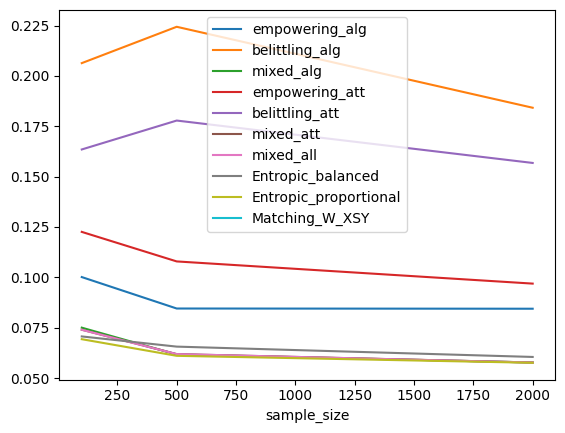

In [17]:
df_result.groupby('sample_size').mean().plot()

### Depending on the criteria mitigation necessary

In [ ]:
df_size = 1000

nmb_prblm = 0

mitigation_fct = {  'Entropic_balanced'     :  Entropic_balanced,
                    'Entropic_proportional' : Entropic_proportional,
                    'Matching_W_XSY'        :  Matching_W_XSY,
                    'sample'                : lambda df, S_name, Y_name, Pred_name, DI_target, dic_name_to_index_mapping : df.sample(200),
    }

list_s       = []
list_y       = []
list_pred    = []
list_P_YS_10 = []
list_P_YS_11 = []
list_DI      = []
list_kl      = []
list_key     = []

for y_incr in tqdm(range(1,9)):
    for s_incr in range(4,9):
        for P_YS_10_incr in range(1,9):
            for P_YS_11_incr in range(P_YS_10_incr,9):

                s_mean = 0.1 + s_incr*0.1
                y_mean = 0.1 + y_incr*0.1
                P_YS_10 = 0.1 + P_YS_10_incr*0.1
                P_YS_11 = 0.1 + P_YS_11_incr*0.1

                df = create_dataset_s_binary(number_ind  = df_size,
                                            s_mean          = s_mean,

                                            y_mean_s1       = y_mean + 0.025,
                                            y_mean_s0       = y_mean - 0.025,

                                            pred_mean_y1_s1 = P_YS_11,
                                            pred_mean_y0_s1 = 1 - y_mean + 0.05,

                                            pred_mean_y1_s0 = P_YS_10,
                                            pred_mean_y0_s0 = 1 - y_mean - 0.05,)

                if DI_fct_dataset(df, 'Pred') < 0.8:
                    for key in mitigation_fct.keys():
                        new_df = mitigation_fct[key](df = df.copy(),
                                                    S_name = 'S',
                                                    Y_name = 'Y',
                                                    Pred_name = 'Pred',
                                                    DI_target = 0.8,
                                                    dic_name_to_index_mapping = dic_name_to_index_mapping)

                        if key in ['Entropic_balanced', 'Entropic_proportional']:
                            list_kl.append(KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values.astype(float), new_df[['S', 'Pred', 'lambda']].values)))
                        elif key == 'Matching_W_XSY':
                            list_kl.append(KL_arr(df[['S', 'Pred']].values, new_df[:,[dic_name_to_index_mapping['S'], dic_name_to_index_mapping['Pred']]]))
                        else:
                            list_kl.append(KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values, new_df[['S', 'Pred']].values)))

                        s_s_mean, s_y_mean, s_p_mean = df.S.mean(), df.Y.mean(), df.Pred.mean()
                        list_s.append(s_s_mean)
                        list_y.append(s_y_mean)
                        list_pred.append(s_p_mean)
                        df_P_YS_10, df_P_YS_11 = df[df.S == 0].Pred.mean(), df[df.S == 1].Pred.mean()
                        df_DI = df_P_YS_10 / df_P_YS_11
                        list_P_YS_10.append(df_P_YS_10)
                        list_P_YS_11.append(df_P_YS_11)
                        list_DI.append(df_DI)
                        list_key.append(key)

 50%|█████     | 4/8 [01:05<01:15, 18.84s/it]

 62%|██████▎   | 5/8 [01:32<01:04, 21.63s/it]

### Result

In [46]:
df_result = pd.DataFrame({'s_mean' : list_s,
                          'P_YS_10' : list_P_YS_10,
                          'P_YS_11' : list_P_YS_11,
                          'DI' : list_DI,
                          'method' : list_key,
                          'KL' : list_kl,
                           })
#df_result[df_result.DI < 0.000001].sort_values('KL')

In [47]:
df_result

,s_mean,P_YS_10,P_YS_11,DI,method,KL
0,0.501,0.673347,0.846307,0.795629,Entropic_balanced,0.000013
1,0.501,0.673347,0.846307,0.795629,Entropic_proportional,0.000013
2,0.501,0.673347,0.846307,0.795629,Matching_W_XSY,0.000038
3,0.501,0.673347,0.846307,0.795629,sample,0.008952
4,0.506,0.651822,0.841897,0.774230,Entropic_balanced,0.000425
...,...,...,...,...,...,...
3359,0.900,0.590000,0.758889,0.777452,sample,0.006583
3360,0.904,0.604167,0.836283,0.722443,Entropic_balanced,0.004122
3361,0.904,0.604167,0.836283,0.722443,Entropic_proportional,0.000879
3362,0.904,0.604167,0.836283,0.722443,Matching_W_XSY,0.001128


<Axes: xlabel='method', ylabel='KL'>

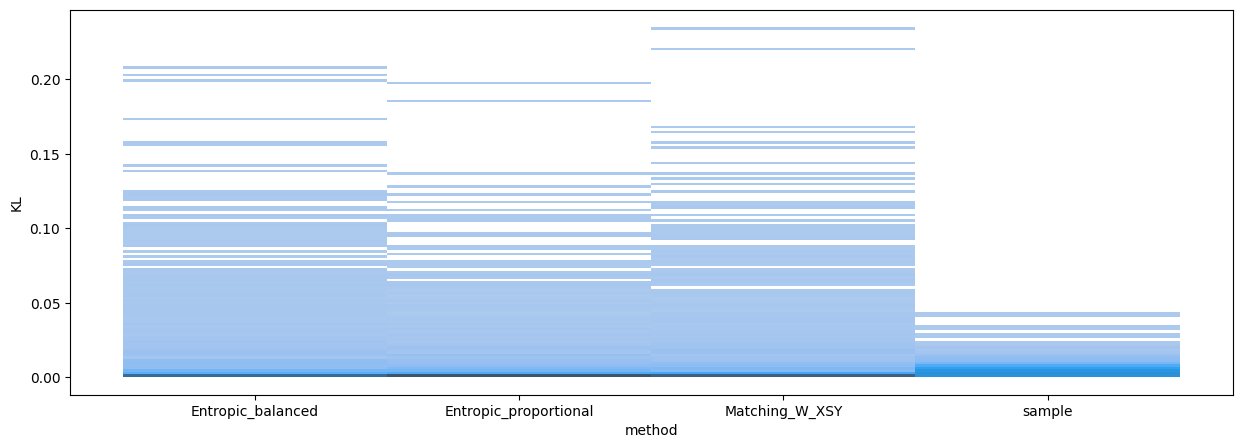

In [48]:
fig, ax = plt.subplots(1,1, figsize = (15,5))
sns.histplot(data = df_result, x = 'method', y = 'KL', ax = ax)

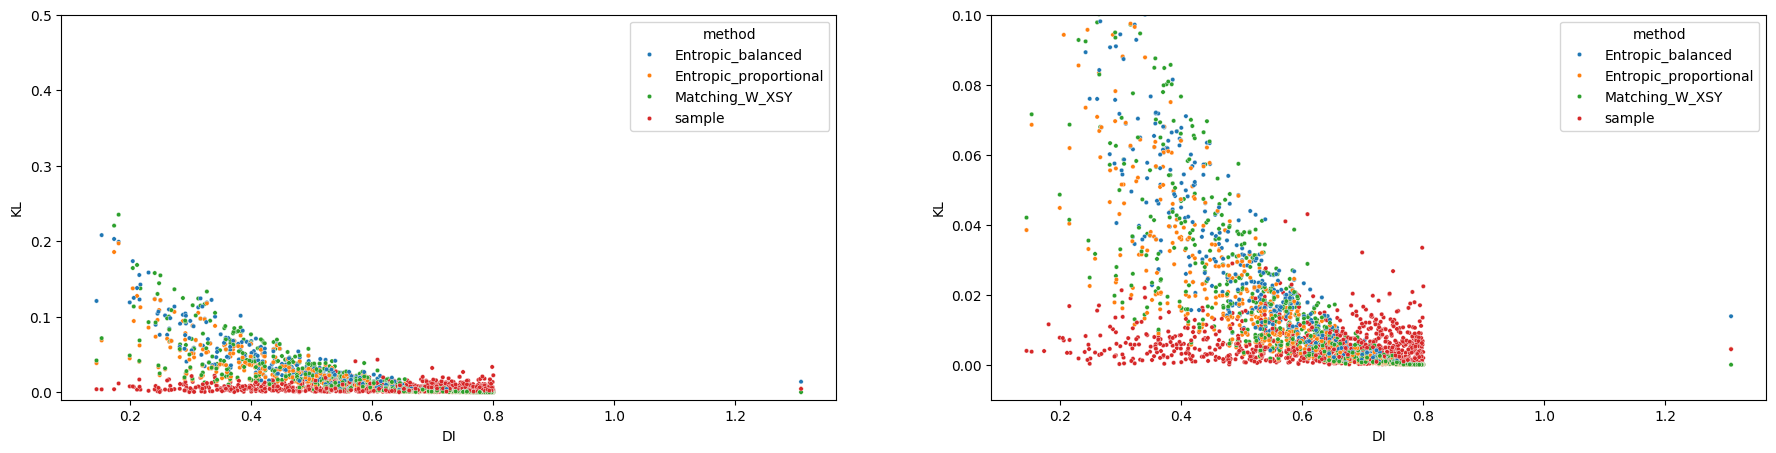

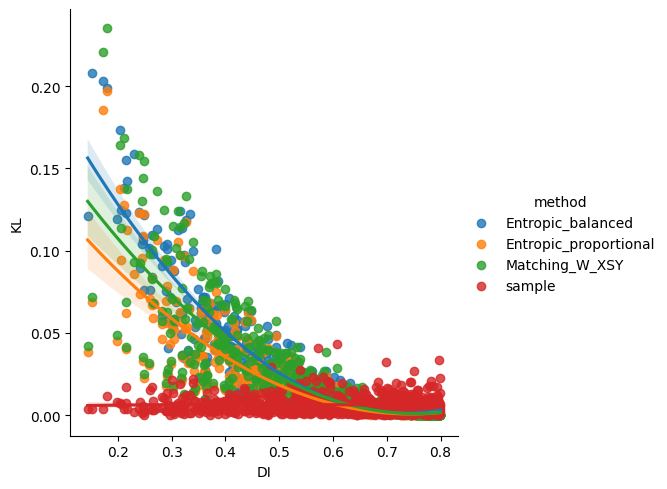

In [52]:
fig, ax = plt.subplots(1,2, figsize = (22,5))
sns.scatterplot(data = df_result, x = "DI", y = "KL", hue = 'method', s = 10, ax = ax[0])
sns.scatterplot(data = df_result, x = "DI", y = "KL", hue = 'method', s = 10, ax = ax[1])
#sns.scatterplot(data = df_result[(df_result.method == 'Gems_regular') | (df_result.method == 'Gems_fair') | (df_result.method == 'sample')], x = "DI", y = "KL", hue = 'method', s = 3, ax = ax[2])
sns.lmplot(data = df_result[df_result.DI < 0.8], x = "DI", y = "KL", hue = 'method',  order = 2)
ax[0].set_ylim(-0.01, 0.5)
ax[1].set_ylim(-0.01, 0.1)
#ax[2].set_ylim(-0.0005, 0.01)
plt.show()

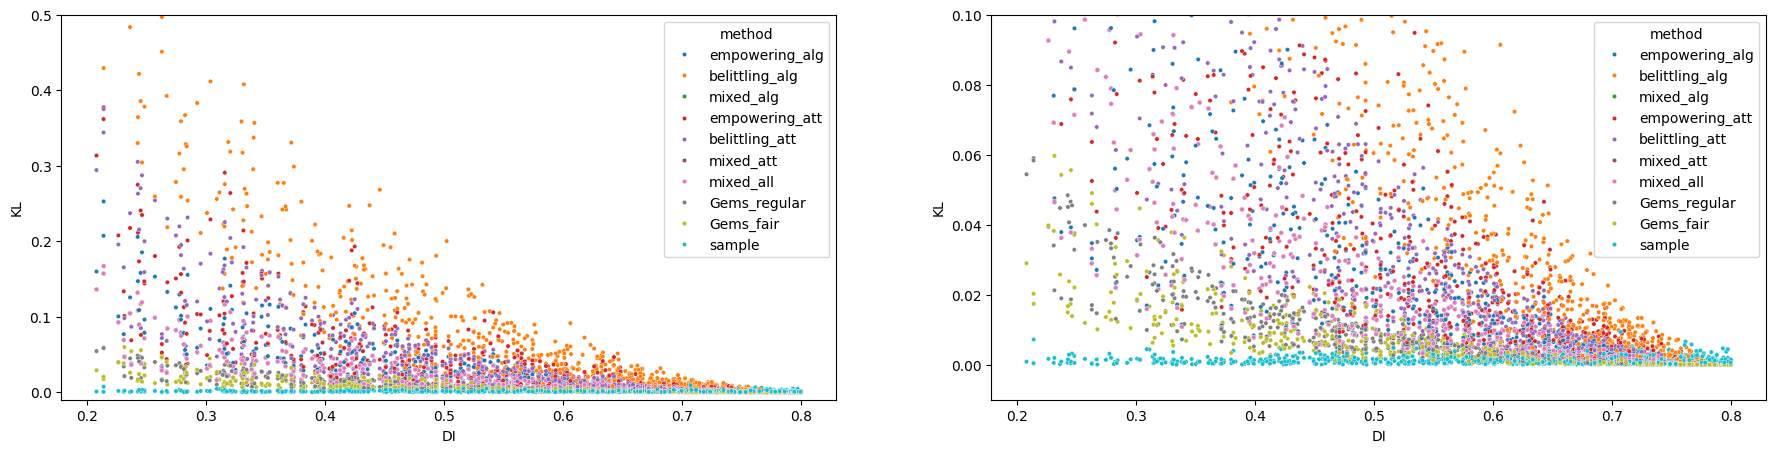

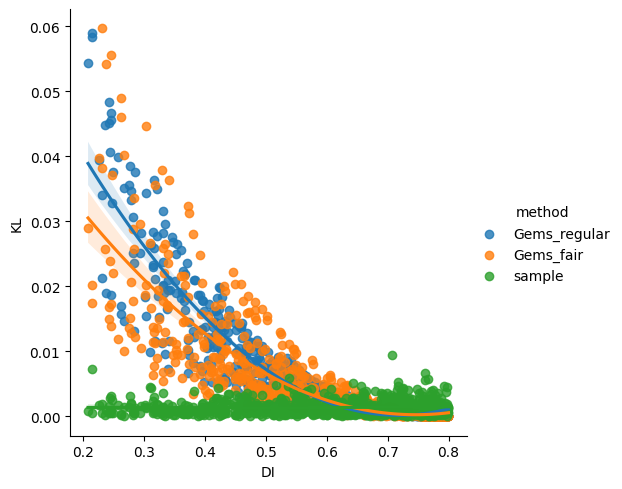

In [59]:
fig, ax = plt.subplots(1,2, figsize = (22,5))
sns.scatterplot(data = df_result, x = "DI", y = "KL", hue = 'method', s = 10, ax = ax[0])
sns.scatterplot(data = df_result, x = "DI", y = "KL", hue = 'method', s = 10, ax = ax[1])
#sns.scatterplot(data = df_result[(df_result.method == 'Gems_regular') | (df_result.method == 'Gems_fair') | (df_result.method == 'sample')], x = "DI", y = "KL", hue = 'method', s = 3, ax = ax[2])
sns.lmplot(data = df_result[(df_result.method == 'Gems_regular') | (df_result.method == 'Gems_fair') | (df_result.method == 'sample')], x = "DI", y = "KL", hue = 'method',  order = 2)
ax[0].set_ylim(-0.01, 0.5)
ax[1].set_ylim(-0.01, 0.1)
#ax[2].set_ylim(-0.0005, 0.01)
plt.show()

In [60]:
df_result

,s_mean,P_YS_10,P_YS_11,DI,method,KL
0,0.4983,0.652581,0.840056,0.776830,empowering_alg,0.000430
1,0.4983,0.652581,0.840056,0.776830,belittling_alg,0.001030
2,0.4983,0.652581,0.840056,0.776830,mixed_alg,0.000345
3,0.4983,0.652581,0.840056,0.776830,empowering_att,0.001180
4,0.4983,0.652581,0.840056,0.776830,belittling_att,0.000485
...,...,...,...,...,...,...
8045,0.8984,0.642717,0.840272,0.764891,mixed_att,0.000204
8046,0.8984,0.642717,0.840272,0.764891,mixed_all,0.000204
8047,0.8984,0.642717,0.840272,0.764891,Gems_regular,0.000058
8048,0.8984,0.642717,0.840272,0.764891,Gems_fair,0.000198


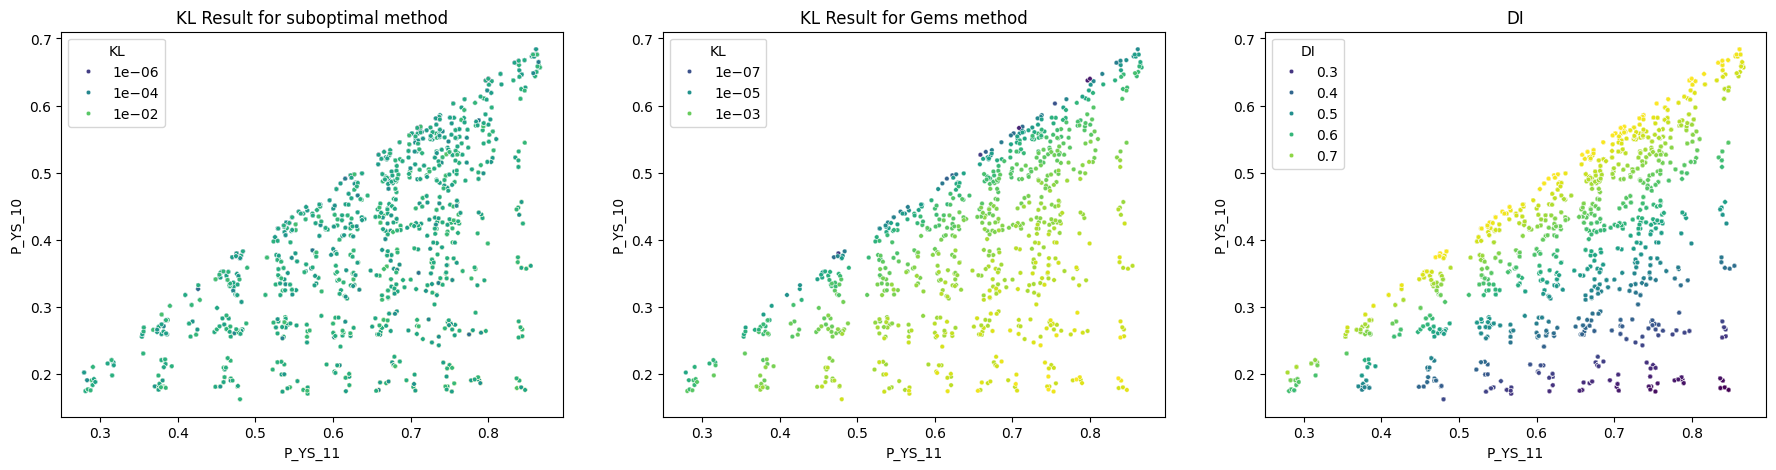

In [61]:
fig, ax = plt.subplots(1,3, figsize = (22,5))
sns.scatterplot(data = df_result[(df_result.method != 'Gems_regular') & (df_result.method != 'Gems_fair')], x = "P_YS_11", y = "P_YS_10", hue = 'KL', s = 10, hue_norm=LogNorm(), ax = ax[0], palette = 'viridis')
sns.scatterplot(data = df_result[(df_result.method == 'Gems_regular') | (df_result.method == 'Gems_fair')], x = "P_YS_11", y = "P_YS_10", hue = 'KL', s = 10, hue_norm=LogNorm(), ax = ax[1], palette = 'viridis')
sns.scatterplot(data = df_result, x = "P_YS_11", y = "P_YS_10", hue = 'DI', s = 10, ax = ax[2], palette = 'viridis')
ax[0].set_title('KL Result for suboptimal method')
ax[1].set_title('KL Result for Gems method')
ax[2].set_title('DI')
plt.show()

## Wasserstein optimisation

### Swap option to consider

In [ ]:
list_changement, list_DI_mod, list_dataset = [], [], []
j = 0
for y_incr in tqdm(range(1,9)):
    for s_incr in range(4,9):
        for P_YS_10_incr in range(1,9):
            for P_YS_11_incr in range(P_YS_10_incr,9):

                s_mean = 0.1 + s_incr*0.1
                y_mean = 0.1 + y_incr*0.1
                P_YS_10 = 0.1 + P_YS_10_incr*0.1
                P_YS_11 = 0.1 + P_YS_11_incr*0.1

                for i in range(50):
                    j +=1
                    df = create_dataset_s_binary(number_ind  = random.randint(500,10000),
                                                s_mean          = s_mean,

                                                y_mean_s1       = y_mean + 0.025,
                                                y_mean_s0       = y_mean - 0.025,

                                                pred_mean_y1_s1 = P_YS_11,
                                                pred_mean_y0_s1 = 1 - y_mean + 0.05,

                                                pred_mean_y1_s0 = P_YS_10,
                                                pred_mean_y0_s0 = 1 - y_mean - 0.05,)

                    Y1S1, Y0S1, Y1S0, Y0S0 = len(df[(df.Pred == 1) & (df.S == 1)]), len(df[(df.Pred == 0) & (df.S == 1)]), len(df[(df.Pred == 1) & (df.S == 0)]), len(df[(df.Pred == 0) & (df.S == 0)])
                    n0, n1 = Y1S0+ Y0S0, Y1S1 + Y0S1
                    PY1S1, PY1S0 = Y1S1/n1, Y1S0 / n0
                    DI =  PY1S0 / PY1S1
                    if DI < 0.8:
                        ## Y1S1
                        list_changement.append('Y1S1 -> Y0S1')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1 - 1, Y0S1 + 1, Y1S0, Y0S0
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        list_changement.append('Y1S1 -> Y1S0')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1 - 1, Y0S1, Y1S0 + 1, Y0S0
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        list_changement.append('Y1S1 -> Y0S0')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1 -1 , Y0S1, Y1S0, Y0S0 + 1
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        ## Y0S1
                        list_changement.append('Y0S1 -> Y1S0')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1, Y0S1 -1, Y1S0+1, Y0S0
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        list_changement.append('Y0S1 -> Y0S0')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1, Y0S1 -1, Y1S0, Y0S0+1
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        list_changement.append('Y0S1 -> Y1S1')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1 +1, Y0S1 -1, Y1S0, Y0S0
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        ## Y1S0
                        list_changement.append('Y1S0 -> Y1S1')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1 +1, Y0S1, Y1S0-1, Y0S0
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        list_changement.append('Y1S0 -> Y0S1')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1, Y0S1 +1, Y1S0-1, Y0S0
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        list_changement.append('Y1S0 -> Y0S0')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1, Y0S1 , Y1S0-1, Y0S0+1
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        ## Y0S0
                        list_changement.append('Y0S0 -> Y1S1')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1 +1, Y0S1, Y1S0, Y0S0-1
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        list_changement.append('Y0S0 -> Y0S1')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1, Y0S1 +1, Y1S0, Y0S0-1
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        list_changement.append('Y0S0 -> Y1S0')
                        Y1S1_n, Y0S1_n, Y1S0_n, Y0S0_n = Y1S1, Y0S1 , Y1S0+1, Y0S0-1
                        n0_n, n1_n = Y1S0_n+ Y0S0_n, Y1S1_n + Y0S1_n
                        PY1S1_n, PY1S0_n = Y1S1_n/n1_n, Y1S0_n / n0_n
                        DI_n =  PY1S0_n / PY1S1_n
                        list_DI_mod.append(DI_n - DI)

                        list_dataset += [j]*12

df = pd.DataFrame({'DI_mod' : list_DI_mod, 'modification' : list_changement, 'dataset' : list_dataset})

In [ ]:
index = df.modification == 'Y1S1 -> Y0S0'
new_df = df.copy()
new_df.loc[index, 'DI_mod'] = df.loc[index, 'DI_mod'].apply(lambda x : x/(2**(1/2)))
new_df

In [ ]:
new_df.groupby('modification').max().sort_values('DI_mod')

In [ ]:
df1 = (df.sort_values(['DI_mod'], ascending=False)
         .groupby("dataset")
         .agg({"DI_mod" : "first", "modification":"first"}))
df1.modification.value_counts()

Y1S1 -> Y0S0,
Y1S0 -> Y0S0,
Y0S1 -> Y0S0,

Y0S1 -> Y1S1,  
Y1S0 -> Y1S1,

never improve DI

### Mitigation results

In [ ]:
df_size = 2000
div_sample_coef = 5
nmb_prblm = 0
j = 10

mitigation_fct = {  'Entropic_balanced'     :  Entropic_balanced,
                    'Replace (S,Ŷ)'         : lambda df, S_index, Y_index, DI_target : mitigation_w( arr = df.values, threshold=DI_target, speed = 1),
                    'Entropic_proportional' : Entropic_proportional,
                    'Matching_W(XSŶ)'        :  Matching_W_XSY,
                    'sample'                : lambda df, S_name, Y_name, Pred_name, DI_target, dic_name_to_index_mapping : pd.concat([df.sample(int(df_size/div_sample_coef))]*div_sample_coef), 
                    #The only reason of why we *div_sample_coef to have the sample to be the same size is because we use a modified Wass distance working only on same number integer resolution (to gain time overall) 
}

list_s       = []
list_y       = []
list_pred    = []
list_P_YS_10 = []
list_P_YS_11 = []
list_DI      = []
list_Wass    = []
list_KL      = []
list_time    = []
list_key     = []

for y_incr in tqdm(range(1,9)):
    for s_incr in range(4,9):
        for P_YS_10_incr in range(1,9):
            for P_YS_11_incr in range(P_YS_10_incr,9):

                s_mean = 0.1 + s_incr*0.1
                y_mean = 0.1 + y_incr*0.1
                P_YS_10 = 0.1 + P_YS_10_incr*0.1
                P_YS_11 = 0.1 + P_YS_11_incr*0.1

                for j_index in range(j):

                    df = create_dataset_s_binary(number_ind  = df_size,
                                                s_mean          = s_mean,

                                                y_mean_s1       = y_mean + 0.025,
                                                y_mean_s0       = y_mean - 0.025,

                                                pred_mean_y1_s1 = P_YS_11,
                                                pred_mean_y0_s1 = 1 - y_mean + 0.05,

                                                pred_mean_y1_s0 = P_YS_10,
                                                pred_mean_y0_s0 = 1 - y_mean - 0.05,)

                    if DI_fct_dataset(df, 'Pred') < 0.8:
                        for key in mitigation_fct.keys():

                            if key[:10] == 'Wass_miti_':
                                t0 = time.time()
                                new_arr, wass_dist  = mitigation_fct[key](df = df.copy(),
                                                        S_index = 0,
                                                        Y_index = 3,
                                                        DI_target = 0.8,
                                                        )
                                list_Wass.append(wass_dist)
                                t1 = time.time()
                                list_time.append(t1-t0)
                                list_KL.append(KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values.astype(float), new_arr[:,[0,3]])))
                            else :
                                t0 = time.time()
                                new_df = mitigation_fct[key](df = df.copy(),
                                                        S_name = 'S',
                                                        Y_name = 'Y',
                                                        Pred_name = 'Pred',
                                                        DI_target = 0.8,
                                                        dic_name_to_index_mapping = dic_name_to_index_mapping)
                                t1 = time.time()
                                list_time.append(t1-t0)
                                bins_old = transform_arr_to_bins(df.values, S_index= 0, Y_index=3)

                                if key in ['Entropic_balanced', 'Entropic_proportional']:
                                    bins_new = transform_arr_to_bins(new_df.values, S_index= 0, Y_index=3, L_index=-1)
                                    list_KL.append(KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values.astype(float), new_df[['S', 'Pred', 'lambda']].values)))
                                elif key == 'Matching_W_XSY':
                                    bins_new = transform_arr_to_bins(new_df, S_index= 0, Y_index=3)
                                    list_KL.append(KL_arr(df[['S', 'Pred']].values, new_df[:,[dic_name_to_index_mapping['S'], dic_name_to_index_mapping['Pred']]]))
                                else:
                                    bins_new = transform_arr_to_bins(new_df.values, S_index= 0, Y_index=3)
                                    list_KL.append(KL_fct(transform_arr_dic_like_KL(df[['S', 'Pred']].values, new_df[['S', 'Pred']].values)))
                                list_Wass.append(Wasserstein_swap_bins(bins_new, bins_old))
                            s_s_mean, s_y_mean, s_p_mean = df.S.mean(), df.Y.mean(), df.Pred.mean()
                            list_s.append(s_s_mean)
                            list_y.append(s_y_mean)
                            list_pred.append(s_p_mean)
                            df_P_YS_10, df_P_YS_11 = df[df.S == 0].Pred.mean(), df[df.S == 1].Pred.mean()
                            df_DI = df_P_YS_10 / df_P_YS_11
                            list_P_YS_10.append(df_P_YS_10)
                            list_P_YS_11.append(df_P_YS_11)
                            list_DI.append(df_DI)
                            list_key.append(key)

100%|██████████| 8/8 [2:39:29<00:00, 1196.13s/it]


In [27]:
df_result = pd.DataFrame({'s_mean' : list_s,
                          'P_YS_10' : list_P_YS_10,
                          'P_YS_11' : list_P_YS_11,
                          'DI' : list_DI,
                          'method' : list_key,
                          'KL' : list_KL,
                          'Wasserstein' : list_Wass,
                          'time' : list_time,
                           })

In [54]:
df_result.groupby('method').mean()

,s_mean,P_YS_10,P_YS_11,DI,KL,Wasserstein,time
method,,,,,,,
Entropic_balanced,0.701423,0.389737,0.646019,0.60519,0.018649,0.070600,0.081847
Entropic_proportional,0.701423,0.389737,0.646019,0.60519,0.013159,0.051680,0.081831
Matching_W(XSŶ),0.701423,0.389737,0.646019,0.60519,0.016563,0.037583,0.995763
"Replace (S,Ŷ)",0.701423,0.389737,0.646019,0.60519,0.016837,0.019048,0.000692
sample,0.701423,0.389737,0.646019,0.60519,0.003065,0.030668,0.000388


[]

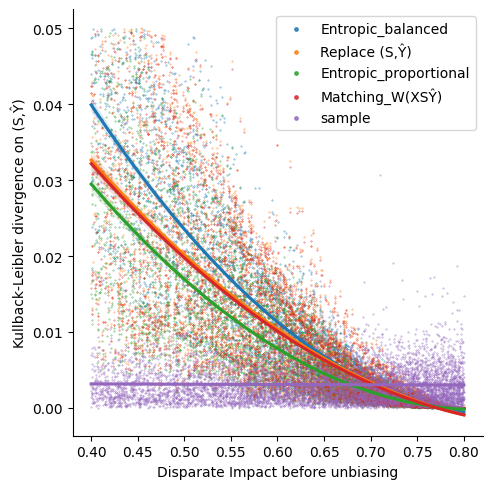

In [55]:
#sns.lmplot(data = df_result, x = "DI", y = "KL", hue = 'method',  order = 2, scatter_kws={"s": 0.2})
sns.lmplot(data = df_result[(df_result.DI > 0.4) & (df_result.KL < 0.05)], x = "DI", y = "KL", hue = 'method',  order = 2, scatter_kws={"s": 0.1}, legend = False)
plt.xlabel('Disparate Impact before unbiasing')
plt.ylabel('Kullback-Leibler divergence on (S,Ŷ)')
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([6.0])
plt.plot()

[]

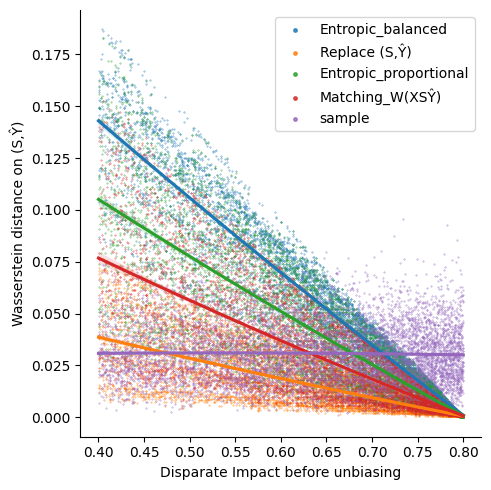

In [52]:
sns.lmplot(data = df_result[df_result.DI > 0.4], x = "DI", y = "Wasserstein", hue = 'method',  order = 2, scatter_kws={"s": 0.1}, legend=False)
plt.xlabel('Disparate Impact before unbiasing')
plt.ylabel('Wasserstein distance on (S,Ŷ)')
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([6.0])
plt.plot()

## Kolmogorov-test

In [24]:
n_sample_per_config = 20

list_df_size         = []
list_s               = []
list_y               = []
list_pred            = []
list_P_YS_10         = []
list_P_YS_11         = []
list_DI              = []
list_ks_result_YS_10 = []
list_ks_result_YS_11 = []
list_sample_red      = []


for exp in tqdm(np.arange(3,6,1)):
    df_size = 10**exp

    for y_incr in range(1,9):
        for s_incr in range(4,9):
            for P_YS_10_incr in range(1,9):
                for P_YS_11_incr in range(P_YS_10_incr,9):

                    s_mean = 0.1 + s_incr*0.1
                    y_mean = 0.1 + y_incr*0.1
                    P_YS_10 = 0.1 + P_YS_10_incr*0.1
                    P_YS_11 = 0.1 + P_YS_11_incr*0.1

                    df = create_dataset_s_binary(number_ind  = df_size,
                                                s_mean          = s_mean,

                                                y_mean_s1       = y_mean + 0.025,
                                                y_mean_s0       = y_mean - 0.025,

                                                pred_mean_y1_s1 = P_YS_11,
                                                pred_mean_y0_s1 = 1 - y_mean + 0.05,

                                                pred_mean_y1_s0 = P_YS_10,
                                                pred_mean_y0_s0 = 1 - y_mean - 0.05,)
                    
                    YS_10, YS_11 = df[df.S == 0].Pred, df[df.S == 1].Pred
                    s_s_mean, s_y_mean, s_p_mean = df.S.mean(), df.Y.mean(), df.Pred.mean()
                    df_P_YS_10, df_P_YS_11 = YS_10.mean(), YS_11.mean()
                    df_DI = df_P_YS_10 / df_P_YS_11

                    for div_sample_coef in [2,5,10,20]:
                        ks_result_YS_10, ks_result_YS_11 = np.zeros(n_sample_per_config), np.zeros(n_sample_per_config)
                        for count in range(n_sample_per_config):
                            df_sample = df.sample(int(df_size/div_sample_coef))
                            sample_YS_10, sample_YS_11 = df_sample[df_sample.S == 0].Pred, df_sample[df_sample.S == 1].Pred
                            ks_result_YS_10[count] = stats.ks_2samp(YS_10, sample_YS_10).pvalue < 0.05
                            ks_result_YS_11[count] = stats.ks_2samp(YS_11, sample_YS_11).pvalue < 0.05


                        
                        list_df_size.append(df_size)
                        list_s.append(s_s_mean)
                        list_y.append(s_y_mean)
                        list_pred.append(s_p_mean)
                        list_P_YS_10.append(df_P_YS_10)
                        list_P_YS_11.append(df_P_YS_11)
                        list_DI.append(df_DI)
                        list_ks_result_YS_10.append(ks_result_YS_10.mean())
                        list_ks_result_YS_11.append(ks_result_YS_11.mean())
                        list_sample_red.append(div_sample_coef)

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Valentin\AppData\Local\Temp\ipykernel_19800\58369183.py:50: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ks_result_YS_10[count] = stats.ks_2samp(YS_10, sample_YS_10).pvalue < 0.05
 67%|██████▋   | 2/3 [08:16<04:22, 262.47s/it]c:\Users\Valentin\Documents\FairWashing\Inspection\inspection\Lib\site-packages\scipy\stats\_ksstats.py:163: RuntimeWarning: overflow encountered in matmul
  Hpwr = np.matmul(Hpwr, H)
100%|██████████| 3/3 [41:08<00:00, 822.91s/it] 


In [ ]:
df_result = pd.DataFrame({'s_mean' : list_s,
                          'y_mean' : list_y,
                          'pred_mean' : list_pred,
                          'P_YS_10' : list_P_YS_10,
                          'P_YS_11' : list_P_YS_11,
                          'DI' : list_DI,
                          'ks_result_YS_10' : list_ks_result_YS_10,
                          'ks_result_YS_11' : list_ks_result_YS_11,
                          'sample_reduction' : list_sample_red
})

In [30]:
df_result.ks_result_YS_10.mean(), df_result.ks_result_YS_11.mean()

(np.float64(0.0013917824074074076), np.float64(0.001050347222222222))

In [37]:
df_result.groupby(['sample_reduction', 'df_size']).agg({
    'ks_result_YS_10' : 'mean',
    'ks_result_YS_11' : 'mean',
})

ks_result_YS_10  ks_result_YS_11
sample_reduction df_size                                  
2                1000            0.000000         0.000000
                 10000           0.000000         0.000000
                 100000          0.000000         0.000035
5                1000            0.000590         0.000486
                 10000           0.000417         0.000208
                 100000          0.000556         0.000451
10               1000            0.001840         0.001632
                 10000           0.001771         0.001354
                 100000          0.001528         0.001146
20               1000            0.003993         0.002326
                 10000           0.003090         0.002326
                 100000          0.002917         0.002639

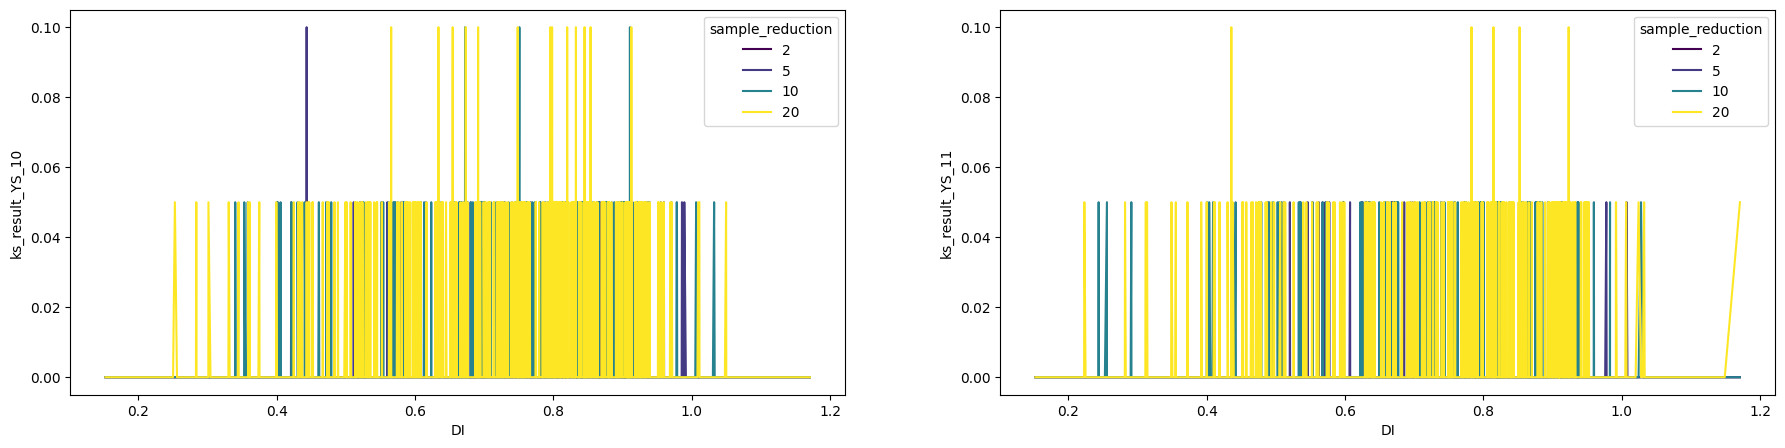

In [35]:
fig, ax = plt.subplots(1,2, figsize = (22,5))
sns.lineplot(data = df_result, x = "DI", y = "ks_result_YS_10", hue = 'sample_reduction',  ax = ax[0], palette = 'viridis')
sns.lineplot(data = df_result, x = "DI", y = "ks_result_YS_11", hue = 'sample_reduction',  ax = ax[1], palette = 'viridis')
plt.show()

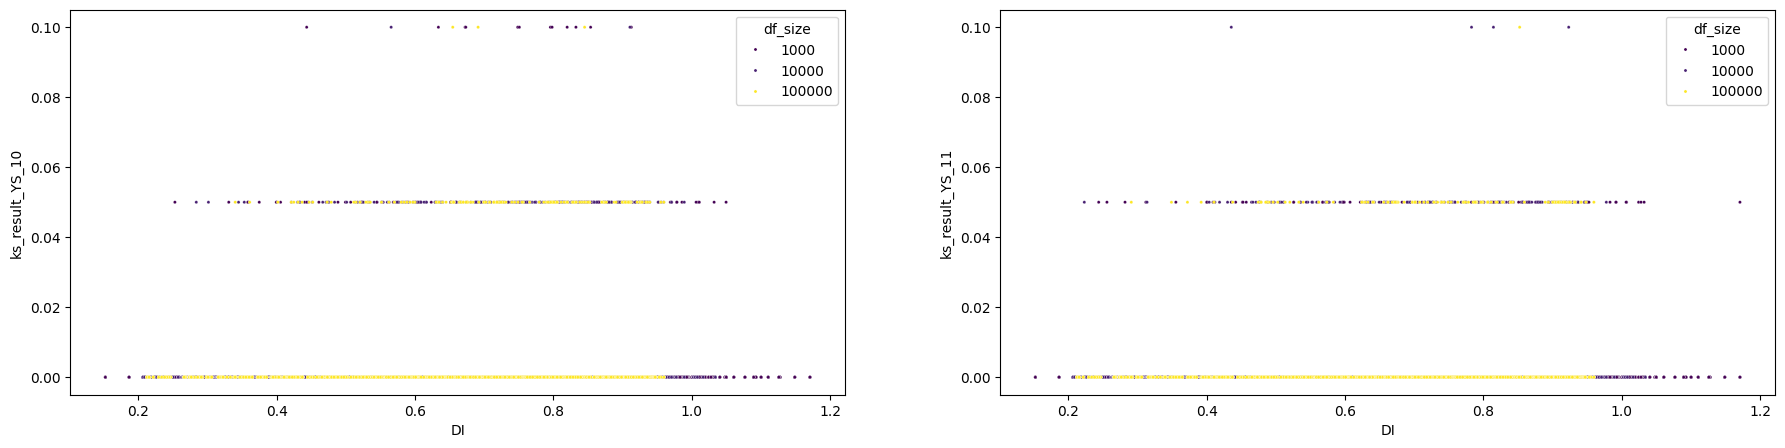

In [32]:
fig, ax = plt.subplots(1,2, figsize = (22,5))
sns.scatterplot(data = df_result, x = "DI", y = "ks_result_YS_10", hue = 'df_size',  ax = ax[0], s = 5, palette = 'viridis')
sns.scatterplot(data = df_result, x = "DI", y = "ks_result_YS_11", hue = 'df_size',  ax = ax[1], s = 5, palette = 'viridis')
plt.show()